In [1]:
import os
from pcxarray import pc_query, prepare_timeseries
from pcxarray.utils import load_census_shapefile
from distributed import Client # dask distributed client
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

In [2]:
client = Client(n_workers=os.cpu_count(), memory_limit="4GB")
display(client)

/Users/dak/projects/pcxarray/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 49935 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:49935/status,
Dashboard: http://127.0.0.1:49935/status,Workers: 10
Total threads: 10,Total memory: 37.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49936,Workers: 0
Dashboard: http://127.0.0.1:49935/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:49959,Total threads: 1
Dashboard: http://127.0.0.1:49960/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:49939,


In [3]:
okt_gdf = load_census_shapefile(level="county", verify=False)
okt_gdf = okt_gdf[okt_gdf['NAME'] == "Oktibbeha"]
okt_gdf = okt_gdf.to_crs("EPSG:32616") # UTM zone 16N

selected_geom = okt_gdf.geometry.union_all()

In [4]:
items_gdf = pc_query(
    collections=["sentinel-2-l2a"],
    geometry=selected_geom,
    datetime='2024-01', # grab all of 2024
    crs=okt_gdf.crs,
    # query={"eo:cloud_cover": {"lt": 50}} # OPTIONAL: filter by cloud cover
)
print(f"Found {len(items_gdf)} items in the query.")

Found 46 items in the query.


In [5]:
da = prepare_timeseries(
    items_gdf=items_gdf,
    geometry=selected_geom,
    crs=okt_gdf.crs,
    bands=["B02", "B04", "B08", "SCL"], # Blue, Red, NIR, Scene Classification Layer
    chunks={"time": 16, "x": 2048 , "y": 2048 }, 
    max_workers=-1, # use 8 workers to submit 
)
display(da)

Constructing dask computation graph: 100%|██████████| 12/12 [00:00<00:00, 42.92timestep/s]


<xarray.DataArray 'reproject-7a9e5c1c5d7645df89255bc05315c03d' (time: 12,
                                                                band: 4,
                                                                y: 3128, x: 3932)> Size: 2GB
dask.array<rechunk-merge, shape=(12, 4, 3128, 3932), dtype=float32, chunksize=(12, 1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 96B 2024-01-02 2024-01-05 ... 2024-01-30
    spatial_ref  int32 4B 32616
  * band         (band) <U3 48B 'B02' 'B04' 'B08' 'SCL'
  * y            (y) float64 25kB 3.716e+06 3.716e+06 ... 3.684e+06 3.684e+06
  * x            (x) float64 31kB 3.055e+05 3.055e+05 ... 3.448e+05 3.448e+05
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     nan

In [6]:
def calculate_evi(da):
    nir = da.sel(band="B08") / 10000
    red = da.sel(band="B04") / 10000
    blue = da.sel(band="B02") / 10000
    
    evi = 2.5 * (nir - red) / (nir + (6 * red) - (7.5 * blue) + 1)
    evi = evi.clip(-1, 1)  # Clip values to [-1, 1]
    return evi

da = da.where(~da.sel(band="SCL").isin([0, 3, 8, 9, 10, 11])) # mask out clouds, shadows, and snow
evi = calculate_evi(da)
monthly_evi = evi.resample(time="1W").mean().compute()

/Users/dak/projects/pcxarray/.venv/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 19.53 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

vmin = monthly_evi.min().values
vmax = monthly_evi.max().values

def update(frame):
    ax.clear()
    monthly_evi.isel(time=frame).plot.imshow(
        ax=ax, add_colorbar=False, cmap='RdYlGn', vmin=vmin, vmax=vmax
    )

    ax.set_title(None)
    ax.set_aspect('equal')
    ax.axis('off')
    x_lim, ylim = ax.get_xlim(), ax.get_ylim()
    okt_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
    
    ax.set_xlim(x_lim)
    ax.set_ylim(ylim)
    
    fig.suptitle(f"Oktibbeha County, MS Sentinel-2 Mean EVI\n" + \
        f"{monthly_evi['time'][frame].dt.strftime('%Y-%m').values}")
    
init_plot = monthly_evi.isel(time=0).plot.imshow(
    ax=ax, add_colorbar=True, cbar_kwargs={'label': 'EVI'},cmap='RdYlGn', vmin=vmin, vmax=vmax
)

ani = FuncAnimation(fig, update, frames=len(monthly_evi['time']), repeat=False)

# show in notebook
HTML(ani.to_jshtml(fps=1, default_mode='once')) 

In [ ]:
import hvplot.xarray
vmin = monthly_evi.min()
vmax = monthly_evi.max()

monthly_evi.hvplot.image(
    x='x', y='y', frame_width=600, frame_height=400,
    cmap='RdYlGn', clim=(vmin, vmax), widget_type='scrubber',
    widget_location='bottom',
    title="Oktibbeha County, MS Sentinel-2 Mean EVI",
    
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'1d78d6ef-2d68-4c2d-bc45-59438cd35602': {'version…

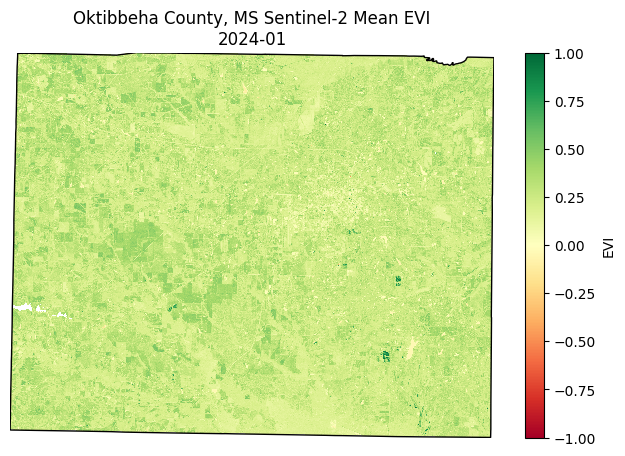

interactive(children=(IntSlider(value=0, description='Frame', max=4), Output()), _dom_classes=('widget-interac…

<function __main__.update(frame)>

In [ ]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

vmin = monthly_evi.min()
vmax = monthly_evi.max()

fig, ax = plt.subplots(figsize=(8, 5))
img = monthly_evi.isel(time=0).plot.imshow(
    ax=ax, cmap='RdYlGn', vmin=vmin, vmax=vmax, add_colorbar=True, cbar_kwargs={'label': 'EVI'}
)
okt_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title(f"Oktibbeha County, MS Sentinel-2 Mean EVI\n"
             f"{monthly_evi['time'][0].dt.strftime('%Y-%m').values}")
ax.axis('off')

def update(frame):
    ax.clear()
    img.set_data(monthly_evi.isel(time=frame).values)
    ax.set_title(f"Oktibbeha County, MS Sentinel-2 Mean EVI\n"
                 f"{monthly_evi['time'][frame].dt.strftime('%Y-%m').values}")
    fig.canvas.draw_idle()

slider = widgets.IntSlider(
    min=0, max=len(monthly_evi['time'])-1, step=1, value=0, description='Frame'
)
widgets.interact(update, frame=slider)